<a href="https://colab.research.google.com/github/nupursjsu/AlternusVera/blob/master/Alternus_Vera_Network_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Alternus Vera**
---
**Let's hunt the Fake News**

**Content**
1. Introduction
  * Objective
  * Description
  * Import libraries
2. Download the datasets
  * Liar Liar
  * Kaggle Fake News
  * Fake News Detection
3. Data Pre-processing
  * Remove null values
  * Visualise the features and text
  * Encode labels into categorical values.
  * Remove unwanted features.
  * Removal of Special Characters and Punctuations
  * Lower casing the text
  * Tokenization
  * Removal of Stop Words
  * Lemmatization
  * Stemming
4. Data Amalgamation.
5. Generate Embedding Matrix
  * Load the GloVe Embeddings.
  * Split the datasets into Train, Test, and Validation sets.
  * Create the tokenizer and fit on text.
  * Generate Sequences & Padding for efficient training.
6. Modeling and training
  * Define the model.
  * Compile the model.
  * Fit the model.
  * Save the model.
7. Conclusion



## Introduction
Determine authenticity of the news.

## Description
**[Network-based](https://arxiv.org/pdf/1708.01967.pdf)**: Social Media users forms different networks in terms of interests, topics, and relations. Dissemination process of Fake News forms an echo chamber cycle.

To represent these types of network patterns for fake news detection we need to extract network-based features. These network-based features can be extracted by constructing specific networks among the users.

Different types of networks can be constructed:
1. Stance Network: The network's nodes indicates all the tweets relevant
to the news and the edges indicates the weights of similarity of stances.
2. Co-occurence Network: The network consists of inter-connection of terms  based on their paired presence within a specified unit of text.
3. Friendship Network: This network indicates the following or followee structure of users who post related tweets.

This notebook uses **Co-occurence network** to fetch network-based features and LSTM network architecture to classify the veracity of the news.

##Import the necessary libraries

In [0]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
# System related libraries
import os
import re
from time import time
# Handle table-like data and matrices
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
# sklearn libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from string import punctuation
from sklearn.preprocessing import LabelEncoder
# NLTK libraries
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
import matplotlib.pyplot as plt
%matplotlib inline
import gensim
# Data Visualization
from wordcloud import WordCloud
# Keras
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, BatchNormalization

from keras.models import Model, Sequential, load_model

from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, Callback, CSVLogger
from keras import backend as K
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Read text file into colaboratory
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Download the [Liar Liar Dataset](https://drive.google.com/file/d/1y3yYF5HHPhH7SyaPwPU9H5HApJzevsFK/view)

[Description about the dataset](https://drive.google.com/open?id=1Ranl1lYPT9aqujmnfKQJLbysdaxebQ3k)

In [0]:
# Google drive link where the dataset is stored.
link = 'https://drive.google.com/open?id=1YVbguC-ZVf7D0fit5Hhq4cgBLrNWcvAR'
fluff, id = link.split('=')
# Download the tsv file.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.tsv')
link = 'https://drive.google.com/open?id=1YVbguC-ZVf7D0fit5Hhq4cgBLrNWcvAR'
fluff, id = link.split('=')
# Download the text file.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('valid.tsv')

Download the [Kaggle Fake News Dataset](https://www.kaggle.com/c/8317/download-all)

In [0]:
# Google drive link where the dataset is stored.
link = 'https://drive.google.com/open?id=19N9D6JONrA75Pd32hl228UoCxZs4K2cF'
fluff, id = link.split('=')
# Download the text file.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('fake_news_train.csv')

Download the [Kaggle Fake News Detection Dataset](https://www.kaggle.com/jruvika/fake-news-detection)

In [0]:
# Google drive link where the dataset is stored.
link = 'https://drive.google.com/open?id=1KEvvfmHNE4v_TvZxOYGuMiPYJxpk30XT'
fluff, id = link.split('=')
# Download the text file.
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data.csv')

###Data Pre-processing

In [0]:
# Read the training and valid data from files
col_names = ['jsonid', 'target', 'headline_text', 'subject', 'speaker', 'speakerjobtitle', 'stateinfo','partyaffiliation', 'barelytruecounts', 'falsecounts','halftruecounts','mostlytrueocunts','pantsonfirecounts','context']

train_news = pd.read_csv('train.tsv', sep='\t', names = col_names, error_bad_lines=False)
valid_news = pd.read_csv('valid.tsv', sep='\t', names = col_names, error_bad_lines=False)

In [0]:
# Display check the dimensions and the first 2 rows of the file.
print('Liar Liar Dataset')
print('train dim:',train_news.shape, 'valid dim:', valid_news.shape)
train_news.iloc[0:2]

Liar Liar Dataset
train dim: (10240, 14) valid dim: (10240, 14)


,jsonid,target,headline_text,subject,speaker,speakerjobtitle,stateinfo,partyaffiliation,barelytruecounts,falsecounts,halftruecounts,mostlytrueocunts,pantsonfirecounts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.


In [0]:
train_news = pd.concat([train_news,valid_news])

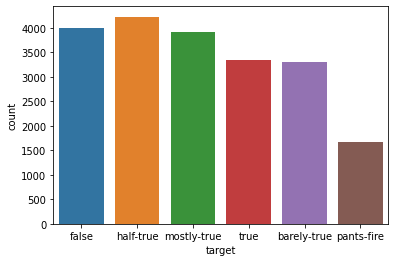

In [0]:
sns.countplot(data=train_news,x='target',label='Count')

In [0]:
df_f = train_news.loc[train_news['target']=='false']
df_pf = train_news.loc[train_news['target']=='pants-fire']
df_bt = train_news.loc[train_news['target']=='barely-true']
df_false = pd.concat([df_f,df_pf,df_bt])

In [0]:
df_t = train_news.loc[train_news['target']=='true']
df_mt = train_news.loc[train_news['target']=='mostly-true']
df_true = pd.concat([df_t,df_mt])

In [0]:
df_false['label']=1
df_true['label']=0

In [0]:
liar = pd.concat([df_false,df_true])

In [0]:
liar['text']=liar['headline_text']
liar = liar[['text','label']]

In [0]:
train = pd.read_csv('fake_news_train.csv')

In [0]:
# Display check the dimensions and the first 2 rows of the file.
print('Fake News Dataset')
print('Dataset dimension:',train.shape)
train.iloc[0:2]

Fake News Dataset
Dataset dimension: (20800, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0


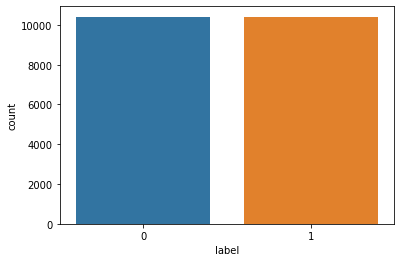

In [0]:
sns.countplot(data=train,x='label',label='Count')

In [0]:
train = train[['text','label']]

In [0]:
train = train.dropna(how='any',axis=0) 

In [0]:
train_fake = pd.read_csv('data.csv')
print('Kaggle Fake News Detection Dataset')
print('Dataset dimension:',train_fake.shape)
train_fake.iloc[0:2]

Kaggle Fake News Detection Dataset
Dataset dimension: (4009, 4)


,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1


In [0]:
train_fake['text'] = train_fake['Body']
train_fake = train_fake[['text','Label']]
train_fake = train_fake.rename(columns={'Label': 'label'})

In [0]:
train_fake = train_fake.dropna(how='any',axis=0)

## Data Amalgamation

In [0]:
df = pd.concat([liar,train,train_fake])

In [0]:
print('Amalgamated Dataset')
print('Dataset dimension:',df.shape)
df.iloc[0:2]

Amalgamated Dataset
Dataset dimension: (41001, 2)


,text,label
0,Says the Annies List political group supports ...,1
3,Health care reform legislation is likely to ma...,1


## Cleaning and Text Preprocessing


In [0]:
def cleaning(raw_text):  
    text = re.sub("[^a-zA-Z]", " ", str(raw_text))
    text =  text.lower()
    text_words = nltk.word_tokenize(text)
    stops = set(nltk.corpus.stopwords.words("english"))
    words = [w for w in  text_words  if not w in stops]
    wordnet_lem = [ WordNetLemmatizer().lemmatize(w) for w in words ]
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in wordnet_lem ]
    return " ".join(stems)

In [0]:
df['clean_text'] = df['text'].apply(cleaning)

Encode labels into Categorical values

In [0]:
train = df.clean_text
label = df.label
le = LabelEncoder().fit(label)
label_encoded = le.transform(label)
print("Classes: ", le.classes_)
label_onehot = to_categorical(label_encoded)
print("Number of One Hot encoded class labels: ", label_onehot.shape[1])

Classes:  [0 1]
Number of One Hot encoded class labels:  2


Splitting Data into train, test & validation sets

In [0]:
x_train, x_val_test, y_train, y_val_test = train_test_split(
    train, label_onehot, test_size=.4, stratify=label_encoded, random_state=21)

x_val, x_test, y_val, y_test = train_test_split(
    x_val_test, y_val_test, test_size=.6, stratify=y_val_test, random_state=21)

Create the tokenizer & fit on text

In [0]:
tokenizer = Tokenizer(num_words=300, lower=True)
tokenizer.fit_on_texts(x_train)

In [0]:
# Dumping tokenizer using joblib which is faster than pickle
joblib.dump(tokenizer, os.path.join('/content/tokenizer.pickle'))

['/content/tokenizer.pickle']

Generating Sequences & Padding for efficient training of our neural network. Transforms each text in texts to a sequence of integers.

In [0]:
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded_sequences = sequence.pad_sequences(train_sequences, maxlen=300)

val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded_sequences = sequence.pad_sequences(val_sequences, maxlen=300)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded_sequences = sequence.pad_sequences(test_sequences, maxlen=300)

del x_train, train_sequences, x_val, val_sequences, x_test, test_sequences

## Words Count

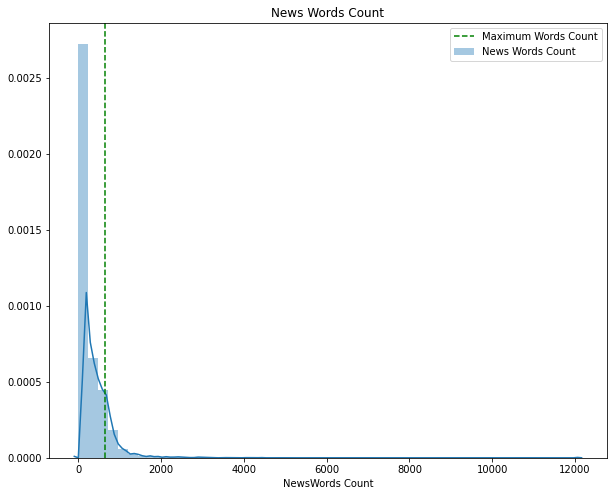

In [0]:
df['news_len'] = df['clean_text'].apply(
    lambda words: len(words.split(" ")))
word_count = np.round(
    df['news_len'].mean() + df['news_len'].std()).astype(int)

plt.figure(figsize=(10, 8))

sns.distplot(df['news_len'], hist=True, kde=True,label='News Words Count')

plt.axvline(x=word_count, color='green',
            linestyle='--', label='Maximum Words Count')
plt.title('News Words Count')
plt.xlabel('NewsWords Count')
plt.legend()
plt.show()

## Word Cloud Visualizations
True News Cloud

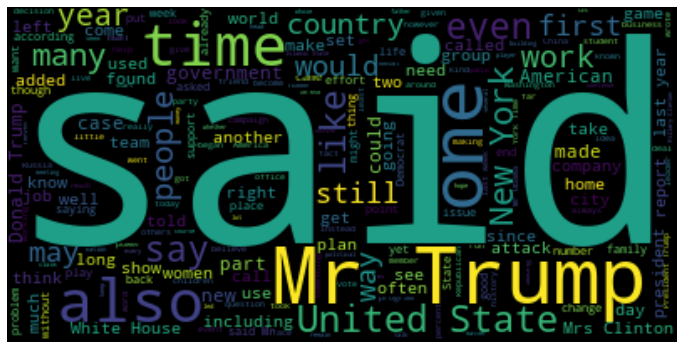

In [0]:
true_tokens = pd.Series(df[df['label'] == 0].text.tolist()).str.cat(sep=' ')

wordcloud = WordCloud(max_font_size=200, stopwords=stopwords.words(
    'english'), random_state=None, background_color='black').generate(true_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Fake News Cloud

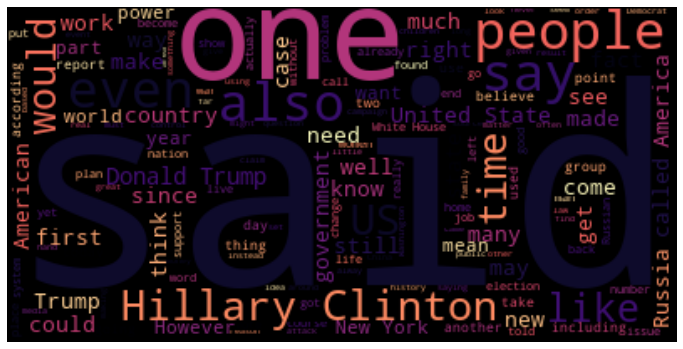

In [0]:
fake_tokens = pd.Series(df[df['label'] == 1].text.tolist()).str.cat(sep=' ')

wordcloud = WordCloud(max_font_size=200, stopwords=stopwords.words(
    'english'), random_state=None, background_color='black', colormap='magma').generate(fake_tokens)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**[GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf)** is an unsupervised learning algorithm for obtaining vector representations for words from their co-occurence matrix (how frequently they co-occur in a text-corpora). 

Download the pre-trained GloVe Vectors

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link = 'https://drive.google.com/open?id=1IY6TLlXcH27-HQhAOu7KoxvHl1nvymO0'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove.6B.300d.txt')

In [0]:
# Load Glove embeddings
print('Loading GloVe word vectors ...')
embeddings_index = dict()

try:
    f = open('/content/glove.6B.300d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
except Exception as e:
    print('Stacktrace', e)
    print('Glove file does not exist.')
finally:
    f.close()

print('Loaded %s Glove word vectors.' % len(embeddings_index))

# Create a weight matrix for all the words
print('\nMapping words to Glove embeddings ...')
embedding_matrix = np.zeros((300, 300))

for word, index in tokenizer.word_index.items():
    if index > 300 - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

print('Shape of Embedding Matrix: ', embedding_matrix.shape)
print('Glove Mapping done!!')

Loading GloVe word vectors ...
Loaded 400000 Glove word vectors.

Mapping words to Glove embeddings ...
Shape of Embedding Matrix:  (300, 300)
Glove Mapping done!!


In [0]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [0]:
# Setting checkpoint & early stopping
checkpoint_path = os.path.join('/content','model_best_weights.{epoch:02d}-{val_accuracy:.4f}.hdf5')
checkpoint = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Early Stopping when val_accuracy remains same with each epoch
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, mode='max')

tensorboard = TensorBoard(
    log_dir='/content/logs', histogram_freq=2000, write_graph=True, write_images=False)

callbacks_list = [checkpoint, tensorboard]

Defining the Model

In [0]:
batch_size = 32
epochs = 10
np.random.seed(21)

In [0]:
model = Sequential()
model.add(Embedding(300, 300, input_length=300,
                    weights=[embedding_matrix], trainable=False))
model.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

Compile the Model

In [0]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          90000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 602       
Total params: 811,802
Trainable params: 721,802
Non-trainable params: 90,000
_________________________________________________________________
None


Train the model for 10 epochs

In [0]:
model.fit(train_padded_sequences, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_padded_sequences, y_val),
          verbose=2, callbacks=callbacks_list)

Train on 24600 samples, validate on 6560 samples
Epoch 1/10
 - 419s - loss: 0.6092 - accuracy: 0.6546 - val_loss: 0.5225 - val_accuracy: 0.7230

Epoch 00001: val_accuracy improved from -inf to 0.72302, saving model to /content/model_best_weights.01-0.7230.hdf5
Epoch 2/10
 - 414s - loss: 0.5155 - accuracy: 0.7263 - val_loss: 0.4763 - val_accuracy: 0.7462

Epoch 00002: val_accuracy improved from 0.72302 to 0.74619, saving model to /content/model_best_weights.02-0.7462.hdf5
Epoch 3/10
 - 418s - loss: 0.4799 - accuracy: 0.7501 - val_loss: 0.4616 - val_accuracy: 0.7636

Epoch 00003: val_accuracy improved from 0.74619 to 0.76357, saving model to /content/model_best_weights.03-0.7636.hdf5
Epoch 4/10
 - 415s - loss: 0.4554 - accuracy: 0.7654 - val_loss: 0.4415 - val_accuracy: 0.7704

Epoch 00004: val_accuracy improved from 0.76357 to 0.77043, saving model to /content/model_best_weights.04-0.7704.hdf5
Epoch 5/10
 - 405s - loss: 0.4242 - accuracy: 0.7808 - val_loss: 0.4318 - val_accuracy: 0.7788

Save the model

In [0]:
model.save('/content/model.hdf5')

Load the model

In [0]:
model = load_model('model.hdf5')

Resume training for 10 more epochs

In [0]:
model.fit(train_padded_sequences, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_padded_sequences, y_val),
          verbose=2, callbacks=callbacks_list)

Train on 24600 samples, validate on 6560 samples
Epoch 1/10
 - 421s - loss: 0.2529 - accuracy: 0.8841 - val_loss: 0.4090 - val_accuracy: 0.8197

Epoch 00001: val_accuracy improved from 0.81311 to 0.81966, saving model to /content/model_best_weights.01-0.8197.hdf5
Epoch 2/10
 - 411s - loss: 0.2246 - accuracy: 0.9020 - val_loss: 0.4205 - val_accuracy: 0.8212

Epoch 00002: val_accuracy improved from 0.81966 to 0.82119, saving model to /content/model_best_weights.02-0.8212.hdf5
Epoch 3/10
 - 409s - loss: 0.1958 - accuracy: 0.9140 - val_loss: 0.4293 - val_accuracy: 0.8326

Epoch 00003: val_accuracy improved from 0.82119 to 0.83262, saving model to /content/model_best_weights.03-0.8326.hdf5
Epoch 4/10
 - 407s - loss: 0.1747 - accuracy: 0.9242 - val_loss: 0.4491 - val_accuracy: 0.8340

Epoch 00004: val_accuracy improved from 0.83262 to 0.83399, saving model to /content/model_best_weights.04-0.8340.hdf5
Epoch 5/10
 - 406s - loss: 0.1545 - accuracy: 0.9339 - val_loss: 0.4543 - val_accuracy: 0.8

Save the model

In [0]:
model.save('/content/model.hdf5')

## Conclusion
LSTMs with pre-trained GloVe embeddings is able to classify the news into fake/not fake giving an accuracy of 95%.